# Atividade 5 - Arquitetura de Computadores - PPGI

Aluno: Victor José de Sousa Koehler

Matrícula: 20211023501

## Introdução

Neste trabalho é apresentado um breve estudo sobre a representação de estrutura de dados e seu impacto na performance dos algoritmos, em particular na cache. Especificamente, foi implementado um conjunto de algoritmos e filtros típicos de processamento de digital de imagens, uma classe que carrega, armazena na memória principal e encapsula o acesso das imagens, e outras estruturas auxiliares para avaliar e comparar o tempo de execução desses filtros mediante algumas escolhas de representação, acesso e ajuste de paramêtros.

Os códigos de interesse foram implementados na linguagem C++, na versão mínima C++17, compilados utilizando GNU GCC versão 9.4.0 (9.4.0-1ubuntu1~20.04.1) e testados em um computador executando o sistema operacional Ubuntu 20.04.1, kernel Linux versão 5.13.0-40-generic#45, equipado com 8GB de RAM e processador AMD Ryzen 7 5700U cujas capacidades de cache L1 de instruções e dados, L2 e L3 são, respectivamente, 256 KiB, 256 KiB, 4 MiB e 8 MiB, como ilustrado na seguinte imagem:

![Detalhes da CPU](report/lscpu.png "Detalhes da CPU")


Diferentes perfis de compilação, otimização e parametrização do compilador são explorados mais adiante. A base de código possui duas dependências externas:

- TCLAP (Licença MIT): http://tclap.sourceforge.net/
- CImg (Licença CeCILL-C/CeCILL ): https://cimg.eu/

## Estrutura do Código

A pasta `src/` abriga os arquivos com os códigos-fonte. Nela há três *headers* (cuja extensão é *.hpp*): `benchmark.hpp` contém estruturas auxiliares, `ImagingAlgorithms.hpp` abriga as implementações dos filtros e algoritmos de processamento de imagens e, finalmente, `Image3D.hpp` contém a(s) classe(s) que encapsula(m) uma imagem a ser processada.

### Filtros de Processamento Digital de Imagens (PDI)

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
from os import listdir as os_listdir

sns.set_theme(style="darkgrid")

A Tabela a seguir apresenta os filtros implementados em `ImagingAlgorithms.hpp` em adição a referência seguida:

In [24]:
pd.set_option('max_colwidth', None)
pd.DataFrame([
    ['Averaging', '#1 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/'],
    ['Luma', '#2 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/'],
    ['Sobel', 'https://en.wikipedia.org/wiki/Sobel_operator'],
    ['Box Blur', 'https://en.wikipedia.org/wiki/Box_blur'],
    ['Desaturação', '#3 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/'],
    ['Decomposição de max', '#4.1 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/'],
    ['Decomposição de min', '#4.2 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/']
], columns=['Método', 'Referência']).set_index('Método')

,Referência
Método,
Averaging,#1 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/
Luma,#2 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/
Sobel,https://en.wikipedia.org/wiki/Sobel_operator
Box Blur,https://en.wikipedia.org/wiki/Box_blur
Desaturação,#3 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/
Decomposição de max,#4.1 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/
Decomposição de min,#4.2 de https://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/


### Alocação Dinâmica de Matrizes

![Representação de Imagem](https://media.geeksforgeeks.org/wp-content/uploads/Pixel.jpg)

Tipicamente, uma imagem digital pode ser vista como uma matriz de três dimensões: largura, altura e canais de cor (imagem acima). Embora a linguagem C++ suporte a declaração e inicialização de *arrays* multidimensionais de forma direta, essa é uma operação que exige que (1) pelo menos algumas das dimensões sejam conhecidas em tempo de compilação ou (2) a declaração e uso do *array* sejam realizados apenas dentro de um mesmo escopo de função (assim o compilador pode, silenciosamente, gerar o código que armazena as dimensões dinâmicas do array e realizar os cálculos de acesso). Por exemplo...

```C++
const int A_const = 3, B_const = 2;

void print_matrix_0(int matrix[A_const][B_const]) { ... } // Permitido, A_const e B_const são conhecidos em tempo de execução
void print_matrix_1(int a, int matrix[a][B_const]) { ... } // Erro: não é possível declarar uma matriz cujo tamanho não é conhecido em tempo de compilação
void print_matrix_2(int b, int matrix[A_const][b]) { ... } // Erro: não é possível declarar uma matriz cujo tamanho não é conhecido em tempo de compilação
void print_matrix_3(int matrix[A_const][]) { ... } // Erro: uma matriz deve possuir tamanho especificado em todas as dimensões, exceto a primeira
void print_matrix_4(int matrix[][B_const]) { ... } // Permitido, uma matriz deve possuir tamanho especificado em todas as dimensões, exceto a primeira
void print_matrix_5(int matrix[][B_const][5]) { ... } // Permitido, uma matriz deve possuir tamanho especificado em todas as dimensões, exceto a primeira
void print_matrix_6(int matrix[][][5]) { ... } // Erro: uma matriz deve possuir tamanho especificado em todas as dimensões, exceto a primeira

void example_matrix() {
    int a, b, x, y, z;
    std::cin >> a >> b >> x >> y >> z;
    int matrix[a][b]; // Permitido, o compilador irá silenciosamente guardar as dimensões dessa matriz em tempo de execução
    ...
    matrix[x][y] = z; // e gerará o assembly necessário para acessá-la.
}
```

Assim sendo, a alocação dinâmica de memória no *heap* do programa é frequentemente usada para a criação de matrizes no C++, principalmente ao usar-se classes. Como resultado, duas estratégias de alocação dinâmica são comumente exploradas e indicadas para iniciantes em fóruns na Internet [https://stackoverflow.com/q/16978675, https://stackoverflow.com/q/45047902, https://stackoverflow.com/q/14202593]: A estratégia de alocação de ponteiros de ponteiros (ou vetores) e a alocação de bloco. Dito isso, muitas vezes tais indicações falham em transmitir as vantagens e desvantagens de tais técnicas, e de fato, a primeira delas, quando mal projetada e implementada, pode ser potencialmente nociva ao desempenho dos programas.

#### Alocação de ponteiros de ponteiros: Pointers

A estratégia da alocação de ponteiros de ponteiros (ou vetores), assim chamada nesse trabalho, pode ser exemplificada da seguinte maneira para matrizes bidimensionais:
```C++
int **matrix = new int*[a];
for (int a_i = 0; a_i < a; a_i++)
    matrix[a] = new int[b];
// ou ainda:
std::vector< std::vector<int> > matrix_vector(a, std::vector<int>(b));
```
Ou no caso de matrizes tridimensionais:
```C++
int ***matrix = new int**[a];
for (int a_i = 0; a_i < a; a_i++) {
    matrix[a] = new int*[b];
    for (int b_i = 0; b_i < b; b_i++)
        matrix[a][b] = new int[c];
}
// ou ainda:
std::vector< std::vector< std::vector<int> > > matrix_vector(a, std::vector< std::vector<int> >(b, std::vector<int>(c)));
```
E assim em diante... Como vantagens, essa solução permite que o programador continue acessando a matriz da mesma forma que antes: `matrix[a][b] = z`, por exemplo, bem como oferece um certo grau de flexibilidade em relação a possibilidades de redimensionamento e tamanhos heterogêneos. Porém, nesse tipo de alocação não há, por definição, garantias de que as regiões recém obtidas estejam próximas umas as outras, nem que estejam ordenadas, o que pode afetar gravemente o princípio da localidade da *cache*. Além disso, embora seja permitido qualquer tamanho arbitrário para a invocação da alocação, deve-se levar em conta que o sistema sempre reserva a memória em blocos, então valores excessivamente pequenos de tamanho no último `for`, como a quantidade de canais de cores de uma típica imagem (3), podem sobreutilizar a memória de maneira ineficiente e até mesmo extrapolar a memória disponível no sistema [https://prog21.dadgum.com/179.html, https://man7.org/linux/man-pages/man3/malloc_usable_size.3.html], o que de fato ocorreu nos experimentos realizados demonstrado mais a frente.

Esta é a estratégia adotada no branch [simplified_before](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/tree/simplified_before).

#### Alocação de blocos: MemBlock

A segunda estratégia consiste em fazer a alocação completa da matriz de uma única vez, o que exige a implementação manual do cálculo da posição do elemento da matriz:

```C++
int a, b, x, y, z;
std::cin >> a >> b >> x >> y >> z;

int *matrix = new int[a*b];
matriz[x][y] = z; // Erro: o compilador não enxerga matrix como uma matriz bi-dimensional
matriz[x*b + y] = z; // Correto: Esse seria o cálculo feito pelo compilador caso fizessemos uma matriz bi-dimensional
```

Esta é a estratégia adotada no branch [simplified_after](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/tree/simplified_after). É importante notar que o cálculo da posição está sendo realizado na classe Image3DMYXC (arquivo `Image3D.hpp`), de forma a encapsular e manter intactas as implementações dos filtros das imagens (em `ImagingAlgorithms.hpp`).

### Ordem de acesso

Para obtermos medidas práticas, definimos arbitrariamente que todos os filtros serão otimizados para percorrer os pixels da imagem na seguinte sequência: Linha -> coluna -> canal de cor. Isto poderia ser traduzido no seguinte `for`:

```C++
for (int y = 0; y < Linhas; y++) {
    for (int x = 0; x < Colunas; x++) {
        for (int c = 0; c < Canais; c++) {
            operacao_sobre_pixel(x, y, c); // imagem.buffer[x][y][c];
        }
    }
}
```

Dessa forma, mantendo-se fixo a ordem de acesso dos filtros, encapsulamos e alteramos a ordem na qual a classe presente em `Image3D.hpp` armazena a imagem na memória:

- XYC: Coluna -> Linha -> Cor (Estratégia adotada no branch [simplified_before](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/tree/simplified_before)).
- XCY: Coluna -> Cor -> Linha
- YXC: Linha -> Coluna -> Cor (Estratégia adotada no branch [simplified_after](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/tree/simplified_after)).
- YCX: Linha -> Cor -> Coluna
- CXY: Cor -> Coluna -> Linha
- CYX: Cor -> Linha -> Coluna

### Resumo das diferenças entre os branches *simplified_before* e *simplified_after*

```C++
/*** BRANCH simplified_before: ***/
struct Image3DXYC {
    uint width, height, channels;
    pixel_unit*** buff;

    void Image3DXYC::init(uint w, uint a, uint c) {
        width = w;
        height = a;
        channels = c;
        if (width*height*channels == 0) return;

        buff = new pixel_unit **[width];
        for (uint c = 0; c < width; c++) {
            buff[c] = new pixel_unit *[height];
            for (uint i = 0; i < height; i++)
                buff[c][i] = new pixel_unit[channels];
        }
    }

    constexpr inline         pixel_unit& at(uint x, uint y, uint c)       { return buff[x][y][c]; }
    constexpr inline const   pixel_unit& at(uint x, uint y, uint c) const { return buff[x][y][c]; }
    
    ...
};
```

```C++
/*** BRANCH simplified_after: ***/
struct Image3DMYXC {
    uint width, height, channels;
    pixel_unit* buff;

    void Image3DMYXC::init(uint w, uint a, uint c) {
        width = w;
        height = a;
        channels = c;
        if (width*height*channels > 0)
            buff = new pixel_unit[width*height*channels];
    }

    constexpr inline         pixel_unit& at(uint x, uint y, uint c)       { return buff[y*width*channels + x*channels + c]; }
    constexpr inline const   pixel_unit& at(uint x, uint y, uint c) const { return buff[y*width*channels + x*channels + c]; }
    
    ...
};
```

### Branch *master*

Finalmente, o branch [master](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/) implementa todas as estratégias acima mencionadas através da especialização de *templates*. Mais precisamente, ele declara a classe `Image3D`, do arquivo `Image3D.hpp`, através da parametrização em tempo de compilação de dois argumentos: `template<PixelOrder order, bool memblock>`, sendo `PixelOrder` um enumerável definido como `{XYC, XCY, YXC, YCX, CXY, CYX}`, `order` como a ordem de acesso, e `memblock=true` para a utilização da estratégia da Alocação de blocos (MemBlock) ou `memblock=false` para Alocação de ponteiros de ponteiros (Pointers).

Resumindo, estas são as variantes implementadas no branch *master* e utilizadas adiante:

- MemBlock@XYC: Coluna -> Linha -> Cor (memória em bloco)
- MemBlock@XCY: Coluna -> Cor -> Linha (memória em bloco)
- MemBlock@YXC: Linha -> Coluna -> Cor (memória em bloco); Estratégia adotada no branch [simplified_after](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/tree/simplified_after)
- MemBlock@YCX: Linha -> Cor -> Coluna (memória em bloco)
- MemBlock@CXY: Cor -> Coluna -> Linha (memória em bloco)
- MemBlock@CYX: Cor -> Linha -> Coluna (memória em bloco)
- Pointers@XYC: Coluna -> Linha -> Cor (ponteiros de ponteiros); Estratégia adotada no branch [simplified_before](/VictorKoehler/PPGI-ARQ-A5ImageBenchmark/tree/simplified_before).
- Pointers@XCY: Coluna -> Cor -> Linha (ponteiros de ponteiros)
- Pointers@YXC: Linha -> Coluna -> Cor (ponteiros de ponteiros)
- Pointers@YCX: Linha -> Cor -> Coluna (ponteiros de ponteiros)
- Pointers@CXY: Cor -> Coluna -> Linha (ponteiros de ponteiros)
- Pointers@CYX: Cor -> Linha -> Coluna (ponteiros de ponteiros)
- XYC: Coluna -> Linha -> Cor 
- XCY: Coluna -> Cor -> Linha

Todos os acessos a imagem de entrada são encapsulados por essa classe, o que permite que `ImagingAlgorithms.hpp` seja utilizada sem modificações entre os parâmetros, o que contribui para a imparcialidade dos experimentos. Além disso, recursos especiais da linguagem, como `inline` e `constexpr` foram extensivamente utilizados para garantir que o compilador otimize tanto quanto possível e mitigue *overheads*.


## Experimentos

### Metodologia

In [25]:
df_ = pd.read_csv('log.csv', sep=', ', engine='python', comment='#', names=['implementation', 'file', 'width', 'height', 'channels', 'time'])
_unit_df, _unit_df_eng = 'milisegundos', 'milliseconds'

def df_time_def(i):
    v, u = i.split(' ')
    u_ = {'seconds': 1, 'milliseconds': 0.001, 'microseconds': 10**(-6), 'nanoseconds': 10**(-9)}
    # u_ = {'seconds': 10**(6), 'milliseconds': 100, 'microseconds': 1, 'nanoseconds': 0.001}
    return float(v)*u_[u]/u_[_unit_df_eng]
# df_

In [26]:
def df_gen(df_):
    df = df_.copy()
    df.time = df.time.apply(df_time_def)
    df = pd.concat([pd.DataFrame(list(df['implementation'].str.split('@')), columns=['impl_strat', 'impl_access']), df], axis=1)
    df['D'] = df[['width', 'height', 'channels']].prod(axis=1)
    df = df[df['D'] != 36]
    return df
df = df_gen(df_)
# df

Foram utilizadas 21 imagens de alta definição (sendo algumas delas variantes redimensionadas de outra). Todas são carregadas sem compressão na memória principal. Além disso, os filtros sempre trabalham sobre um *buffer* de mesmo tamanho da imagem original, o que implica que o teto de consumo de memória é (ligeiramente maior que) o dobro da quantidade de *pixels* (largura X altura X canais). A tabela abaixo relaciona a dimensão de cada imagem:

In [27]:
_df1 = df.pivot_table(values='time', index='file', columns=['impl_strat', 'impl_access'], aggfunc='mean')
df[['file', 'width', 'height', 'channels', 'D']].drop_duplicates().rename(
    {'width': 'largura', 'height': 'altura', 'channels': 'canais', 'D': 'Dimensões ( = largura * altura * canais)', 'file': 'Arquivo'}, axis=1).set_index('Arquivo')

,largura,altura,canais,Dimensões ( = largura * altura * canais)
Arquivo,,,,
input/166370483-56cb36da5f9b5879cc54103c.jpg,5760,3840,3,66355200
input/Airbus_Pleiades_50cm_8bit_RGB_Yogyakarta.jpg,5494,5839,3,96238398
input/Airbus-Spot6-50cm-St-Benoit-du-Lac-Quebec-2014-09-04.jpg,5181,4828,3,75041604
input/Everest_kalapatthar.jpg,2304,3456,3,23887872
input/Foto-011.tif,2784,1891,3,15793632
input/GeoEye_GeoEye1_50cm_8bit_RGB_DRA_Mining_2009FEB14_8bits_sub_r_15.jpg,11846,9945,3,353425410
input/Mount-Nyiragongo-DRC.jpg,5616,3744,3,63078912
input/potw1508a.tif,9000,2568,3,69336000
input/santa-ana-vulkan.jpg,12821,5591,3,215046633


### Comparação entre diferentes Ordens de Acesso e Estratégias de Alocação

Nos experimentos realizados a seguir, o programa foi compilado utilizando o comando `make`, que pela receita padrão do arquivo `Makefile`, utiliza as seguintes opções de compilação: `g++ -O5 -DNDEBUG -Wall -Wextra -Wl,--no-relax -std=c++17 -m64 -fPIC -fno-strict-aliasing -fexceptions -DIL_STD -MM`. A tabela abaixo apresenta os resultados relacionando a dimensão da imagem (linha), por cada algoritmo/estratégia (coluna) em função da soma do tempo de execução de todos os filtros (valores).

Valores em NaN implicam que a estratégia ultrapassou o limite de memória do computador e teve sua execução abruptamente interrompida pelo sistema operacional. É possível notar que, apesar de receberem a mesma imagem, apenas duas estratégias apresentaram esse comportamento: Pointers@XYC e Pointers@YXC. Trata-se do problema mencionado na subseção "Alocação de ponteiros de ponteiros: Pointers" na qual há um sobreuso ineficiente de memória ao tentar-se alocar uma imagem de dimensões (11846, 9945, 3) da seguinte maneira:

```C++
typedef unsigned char pixel_unit;
matrix = new pixel_unit **[width]; // Código de alocação da matriz da estratégia Pointers@XYC
for (uint c = 0; c < width; c++) { // No caso da estratégia Pointers@YXC, inverte-se este for com o de baixo
    matrix[c] = new pixel_unit *[height];
    for (uint i = 0; i < height; i++)
        matrix[c][i] = new pixel_unit[channels]; // mas mantém essa linha, na qual channels = 3
```

Note que a última linha, que aloca de maneira ineficiente 3 `pixel_unit` (3 bytes), é invocada `width*height` vezes, então embora o consumo teórico de memória desta imagem em particular seja 353425410 bytes (0.353425 GB), na prática o consumo atinge níveis suficientes para a invocação do *OOM Killer* do Linux no computador utilizado.

In [28]:
_df2_gen = lambda df: df.pivot_table(values='time', index='D', columns=['impl_strat', 'impl_access'], aggfunc='mean')
_df2 = _df2_gen(df)
_df2

impl_strat       MemBlock                                                                         Pointers                                                                     
impl_access           CXY          CYX           XCY           XYC          YCX          YXC           CXY          CYX            XCY            XYC          YCX          YXC
D                                                                                                                                                                              
996360          20.440667    16.435667     22.173333     18.851333    17.334000    17.916000     22.743667    17.652000      23.312000      65.132667    19.928000    22.098667
1998000         64.114333    29.502333     57.353667     43.738333    32.949333    31.083667     47.737333    31.879667      57.574000     218.473000    33.549333    54.399333
3497472         77.994667    52.248333     76.420667     67.383333    55.673667    52.642667    128.427333    52.885333      87.244000     246.954667    54.665333    77.236333
7998000        233.981667   117.091333    197.320000    209.856667   126.790333   119.141667    217.789000   121.870667     239.043000     680.833667   123.345667   176.654667
13996800       460.019333   208.473000    459.114667    318.461333   224.091333   212.956667   2339.349667   216.731333     486.422333    1207.693667   213.673333   338.442000
15793632       466.791333   231.553000    471.078667    357.447333   245.677667   238.115000    454.044667   240.888333     503.899667    1173.632667   240.494333   342.284000
23887872       942.230000   350.817333   1047.852333    591.363000   375.607333   363.831667    926.000000   365.730000    1259.111333    2071.352667   360.592333   516.206667
24883200       759.130333   365.757000    773.745667    543.332333   388.356333   372.281333    804.035000   379.279667     922.715333    2762.609000   371.984667   539.343000
33350616      1195.606667   490.582000   1211.550333    735.683333   521.377667   505.261667   1241.799000   515.663333    1569.542667    4683.350333   505.319000   795.234667
50900328      2492.329667   755.580667   2557.156667   1418.318667   792.941667   770.896333   2703.547333   784.621000    4978.812000   10545.231667   776.434333  1188.224667
63078912      3263.519333   934.540333   4591.378000   1636.500667   962.469333   942.192000   3154.772333   972.868333   11120.778333   15377.141667   958.501333  1345.092667
66355200      9158.682333   963.540000  11510.572000   3705.418667  1016.346000   980.333000   3317.960333  1009.695000   12005.939333   17846.753333   991.657333  1437.234667
69336000      4694.248333  1023.933667   5688.455667   1558.097000  1061.930667  1041.550333   5827.827333  1071.747667   10810.875667   18164.506000  1046.877333  1481.054333
75041604      3919.411333  1100.601333   5288.495667   1973.654000  1161.531667  1117.459000   3935.947667  1154.039333   12715.313000   18067.555333  1131.692333  1599.297333
88347468      5242.465333  1307.342333   7767.239000   2423.848667  1386.223667  1333.235333   6337.413333  1371.185333   17499.515333   26414.231333  1347.790000  1895.345667
96238398      6049.649667  1418.701667   7019.030667   2569.690667  1485.179333  1443.217333   6004.635000  1489.578000   16645.077667   24190.003333  1456.632667  2069.328667
198770616    32702.273667  2983.268333  26173.870000   6535.113000  3087.256000  3021.726000  29500.116333  3098.926333   62346.572667   99275.444667  3046.404333  4264.367333
215046633    40798.701667  3179.306667  37767.531000   9971.327667  3290.931000  3260.121333  43676.689667  3361.746667   69456.694000  106470.324667  3271.913667  4627.885000
217950336    37460.001333  3204.053667  28663.491333   7035.605000  3330.743000  3260.772667  42435.586000  3357.801667   66226.905333  102756.291667  3274.343667  4661.320333
353425410    94195.424667  5238.211000  59692.441333  18928.665333  5450.456667  5331.179667  98720.135667  5538.269333  114701.

A mesma tabela anterior, mas ordenada de modo que a estratégia mais a esquerda possui o menor tempo computacional total/médio.

In [29]:
def _df2s_gen(df):
    _df2s = _df2_gen(df)
    _df2s.loc['mean'] = _df2s.mean(numeric_only=True, axis=0)
    _df2s.sort_values(by='mean', axis=1, inplace=True)
    _df2s.drop('mean', inplace=True)
    return _df2s
_df2s = _df2s_gen(df)
_df2s

impl_strat      MemBlock                  Pointers     MemBlock     Pointers                   MemBlock                                  Pointers                              
impl_access          CYX          YXC          YCX          YCX          CYX          YXC           XYC           XCY           CXY           CXY            XCY            XYC
D                                                                                                                                                                              
996360         16.435667    17.916000    19.928000    17.334000    17.652000    22.098667     18.851333     22.173333     20.440667     22.743667      23.312000      65.132667
1998000        29.502333    31.083667    33.549333    32.949333    31.879667    54.399333     43.738333     57.353667     64.114333     47.737333      57.574000     218.473000
3497472        52.248333    52.642667    54.665333    55.673667    52.885333    77.236333     67.383333     76.420667     77.994667    128.427333      87.244000     246.954667
7998000       117.091333   119.141667   123.345667   126.790333   121.870667   176.654667    209.856667    197.320000    233.981667    217.789000     239.043000     680.833667
13996800      208.473000   212.956667   213.673333   224.091333   216.731333   338.442000    318.461333    459.114667    460.019333   2339.349667     486.422333    1207.693667
15793632      231.553000   238.115000   240.494333   245.677667   240.888333   342.284000    357.447333    471.078667    466.791333    454.044667     503.899667    1173.632667
23887872      350.817333   363.831667   360.592333   375.607333   365.730000   516.206667    591.363000   1047.852333    942.230000    926.000000    1259.111333    2071.352667
24883200      365.757000   372.281333   371.984667   388.356333   379.279667   539.343000    543.332333    773.745667    759.130333    804.035000     922.715333    2762.609000
33350616      490.582000   505.261667   505.319000   521.377667   515.663333   795.234667    735.683333   1211.550333   1195.606667   1241.799000    1569.542667    4683.350333
50900328      755.580667   770.896333   776.434333   792.941667   784.621000  1188.224667   1418.318667   2557.156667   2492.329667   2703.547333    4978.812000   10545.231667
63078912      934.540333   942.192000   958.501333   962.469333   972.868333  1345.092667   1636.500667   4591.378000   3263.519333   3154.772333   11120.778333   15377.141667
66355200      963.540000   980.333000   991.657333  1016.346000  1009.695000  1437.234667   3705.418667  11510.572000   9158.682333   3317.960333   12005.939333   17846.753333
69336000     1023.933667  1041.550333  1046.877333  1061.930667  1071.747667  1481.054333   1558.097000   5688.455667   4694.248333   5827.827333   10810.875667   18164.506000
75041604     1100.601333  1117.459000  1131.692333  1161.531667  1154.039333  1599.297333   1973.654000   5288.495667   3919.411333   3935.947667   12715.313000   18067.555333
88347468     1307.342333  1333.235333  1347.790000  1386.223667  1371.185333  1895.345667   2423.848667   7767.239000   5242.465333   6337.413333   17499.515333   26414.231333
96238398     1418.701667  1443.217333  1456.632667  1485.179333  1489.578000  2069.328667   2569.690667   7019.030667   6049.649667   6004.635000   16645.077667   24190.003333
198770616    2983.268333  3021.726000  3046.404333  3087.256000  3098.926333  4264.367333   6535.113000  26173.870000  32702.273667  29500.116333   62346.572667   99275.444667
215046633    3179.306667  3260.121333  3271.913667  3290.931000  3361.746667  4627.885000   9971.327667  37767.531000  40798.701667  43676.689667   69456.694000  106470.324667
217950336    3204.053667  3260.772667  3274.343667  3330.743000  3357.801667  4661.320333   7035.605000  28663.491333  37460.001333  42435.586000   66226.905333  102756.291667
353425410    5238.211000  5331.179667  5374.813333  5450.456667  5538.269333          NaN  18928.665333  59692.441333  94195.424

A mesma tabela ordenada anterior, mas colorida e anotada com as somatórias das linhas e colunas (a direita e em baixo), bem como inclui uma linha extra com a porcentagem relativa a implementação de melhor desempenho.

Valores em vermelho claro implicam que a estratégia ultrapassou o limite de memória do computador e teve sua execução abruptamente interrompida pelo sistema operacional.

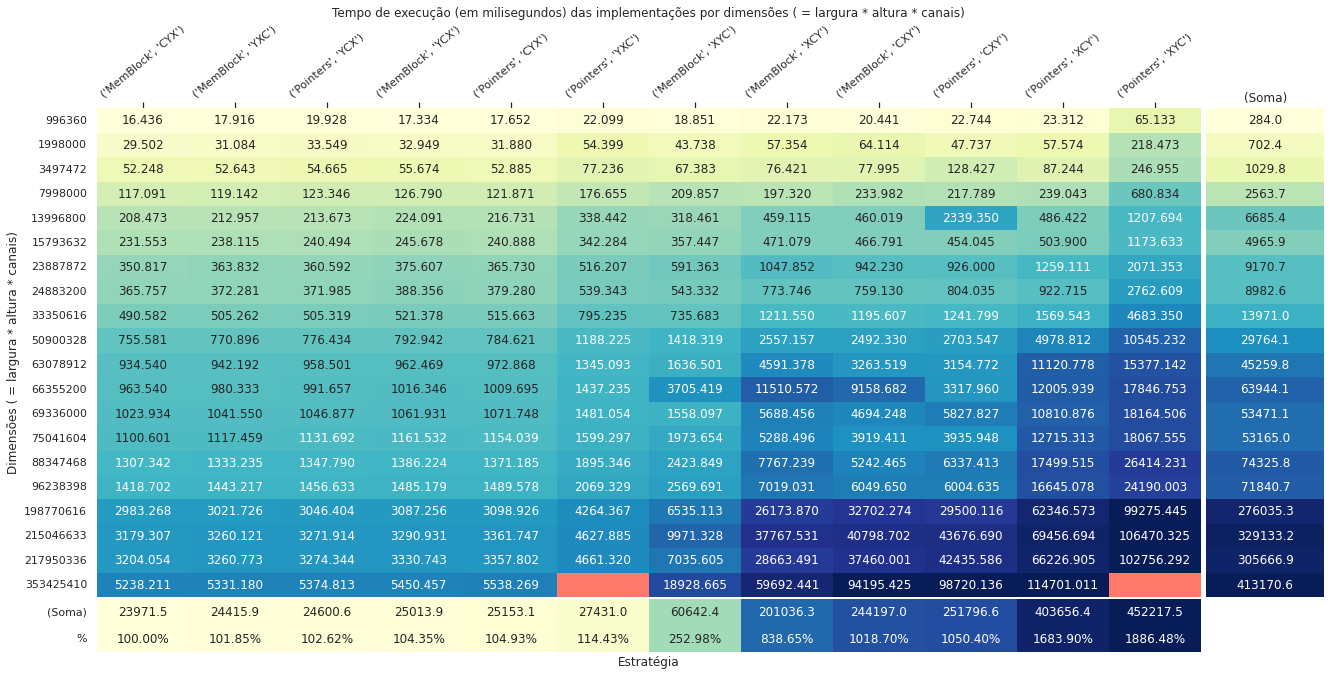

In [30]:
def _df2s_heatmap(_df2s):
    fig_sz = (22, 10)
    fig = plt.figure(figsize=fig_sz)
    fig_d, fig_d1, fig_u1 = 40, 36, 4
    ax1 = plt.subplot2grid((fig_d, fig_d), (0, 0), colspan=fig_d1, rowspan=fig_d1, title='Tempo de execução (em '+_unit_df+') das implementações por dimensões ( = largura * altura * canais)')
    axb = plt.subplot2grid((fig_d, fig_d), (fig_d1, 0), colspan=fig_d1, rowspan=fig_u1)
    axr = plt.subplot2grid((fig_d, fig_d), (0, fig_d1), colspan=fig_u1, rowspan=fig_d1)

    _g = sns.heatmap(np.log(_df2s), annot=_df2s, ax=ax1, fmt='.3f', robust=True, cmap="YlGnBu", linecolor='b', cbar = False)
    _g.set_facecolor('xkcd:salmon')
    # sns.heatmap(pv, ax=ax1, annot=True, cmap="YlGnBu",mask=mask, linecolor='b', cbar = False)
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(_df2s.columns,rotation=40)
    def __hmap_sides(d, axis, colorvalue=False):
        r = pd.DataFrame(d.sum(axis=axis))
        if colorvalue:
            if axis == 0: r['%'] = r
            r = np.log(r)
        elif axis == 0:
            class DummyStrFormater(str):
                def __init__(self, s):
                    self.s = s            
                def __format__(self, fmt):
                    return self.s

            r['%'] = (r/r.min()).applymap(lambda x: DummyStrFormater('{:.2f}%'.format(100*x)))
        return r.transpose() if axis == 0 else r

    sns.heatmap(__hmap_sides(_df2s, 0, True), annot=__hmap_sides(_df2s, 0), ax=axb, fmt='.1f', robust=True, cmap="YlGnBu", cbar=False, xticklabels=False)
    sns.heatmap(__hmap_sides(_df2s, 1, True), annot=__hmap_sides(_df2s, 1), ax=axr, fmt='.1f', robust=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    ax1.set_ylabel('Dimensões ( = largura * altura * canais)')
    axb.set_xlabel('Estratégia')
    axr.set_ylabel('')
    axr.set_title('(Soma)')
    axb.set_yticklabels(['(Soma)', '%'], rotation=0)
    # _ = snsheatmap(np.log(_df2s), title='', xlabel='')

_df2s_heatmap(_df2s)

É possível observar nas tabelas que as implementações MemBlock@CYX, MemBlock@YXC, Pointers@YCX, MemBlock@YCX, Pointers@CYX e Pointers@YXC, todas nas quais as linhas são indexadas antes das colunas (em harmonia com a forma de acesso dos filtros) foram melhores, em média, em termos de tempo de execução do que aquelas em que ocorre o contrário (MemBlock@XYC, MemBlock@XCY, MemBlock@CXY, Pointers@CXY, Pointers@XCY, Pointers@XYC), tornando possível dividir naturalmente a tabela em duas partes: As 6 primeiras colunas da tabela compreendem as estratégias linhas -> colunas (YX), e as 6 últimas contém os resultados das classes que alocaram as matrizes no formato colunas -> linhas (XY). De fato, a implementação MemBlock@CYX, que obteve os menores tempos, foi 2.5 vezes mais rápida que MemBlock@XYC, e 18 vezes mais rápida que Pointers@XYC.

Dito isso, a posição de acesso do canal de cor não apresentou impacto significativo no desempenho (ao menos nas 6 primeiras colunas), tanto é que a implementação com melhor desempenho, MemBlock@CYX, acessa os elementos indexando-os por meio de cor -> linha -> coluna, diferente da forma fixada previamente na implementação dos filtros das imagens (linha -> coluna -> cor = YXC). Assim sendo, MemBlock@CYX é consistentemente 1.8% mais rápida que MemBlock@YXC e 4.3% mais rápida que MemBlock@YCX.

Ademais, a estratégia da alocação de bloco de memória mostrou-se apenas ligeiramente superior nas seis primeiras colunas, com MemBlock@CYX sendo 2.62% mais rápida que Pointers@YCX e 4.92% que Pointers@CYX. Porém nas últimas colunas, as quais empregam implementações ineficientes de acesso aos índices, tal estratégia não apenas demonstrou-se claramente superior a *Pointers*, mas apresentou clara evidência de melhora de acordo com a posição que o canal de cores ocupa: MemBlock@XYC tomou 60642.35 milissegundos, MemBlock@XCY 201036.27 milissegundos e MemBlock@CXY 244197.01 milissegundos.

Por fim, os gráficos a seguir apresentam uma visão das tabelas apresentadas anteriormente:

In [31]:
def default_plot(title='', xlabel=None, ylabel=None, invok=None, figsize=(16, 10), **kwargs):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    fig.set_facecolor('white')
    if invok is not None: invok(fig, **kwargs)
    plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    return fig

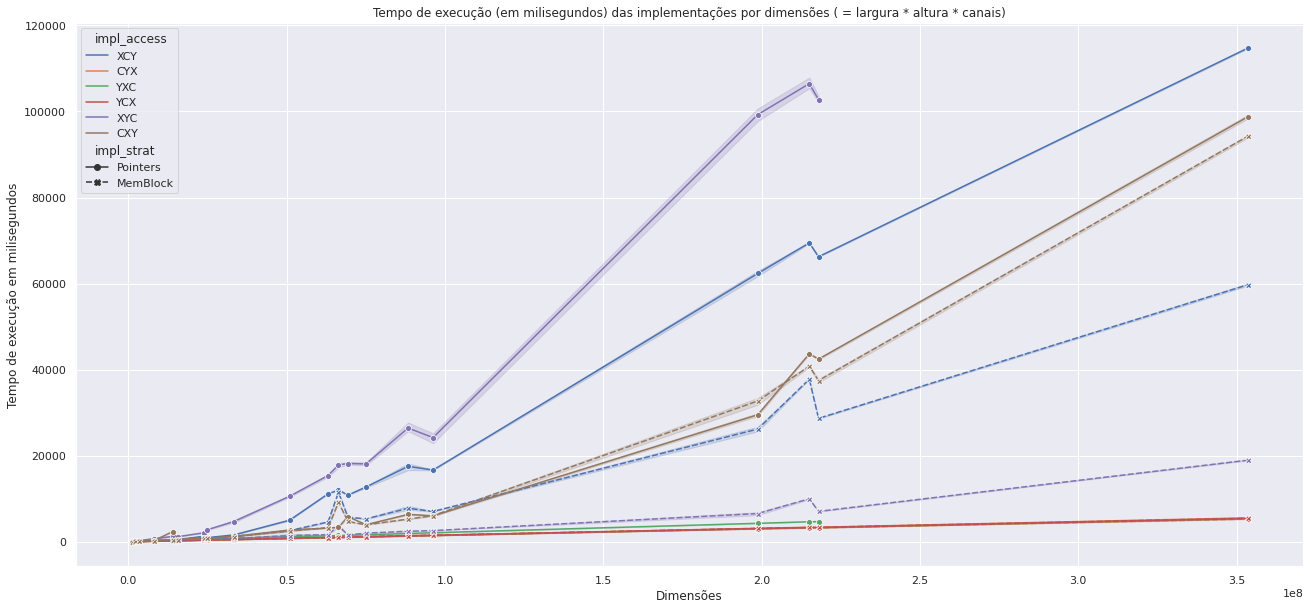

In [32]:
def _plot_linegraph(df, extr='', ret=False, set_xlim=None, set_ylim=None, lim_autoadjust=True):
    default_plot('Tempo de execução (em '+_unit_df+') das implementações por dimensões ( = largura * altura * canais)' + extr,
        'Dimensões', 'Tempo de execução em '+_unit_df, figsize=(22, 10))
    # grid = sns.pointplot(x="D", y="time", hue="impl_access", linestyle="impl_strat", data=df)
    # grid.set(xscale="log", yscale="log")
    r = sns.lineplot(x="D", y="time", markers=True, hue="impl_access", style="impl_strat", data=df)
    if set_xlim:
        r.set_xlim(*set_xlim)
        if lim_autoadjust and not set_ylim:
            rdf = df[(set_xlim[0] <= df['D']) & (df['D'] <= set_xlim[1])]['time']
            padd = 0.05*(rdf.max() - rdf.min())
            r.set_ylim(rdf.min() - padd, rdf.max() + padd)
    if set_ylim:
        r.set_ylim(*set_ylim)
        if lim_autoadjust and not set_xlim:
            rdf = df[(set_ylim[0] <= df['time']) & (df['time'] <= set_ylim[1])]['D']
            r.set_xlim(rdf.min() - padd, rdf.max() + padd)
    if ret: return r
_plot_linegraph(df)

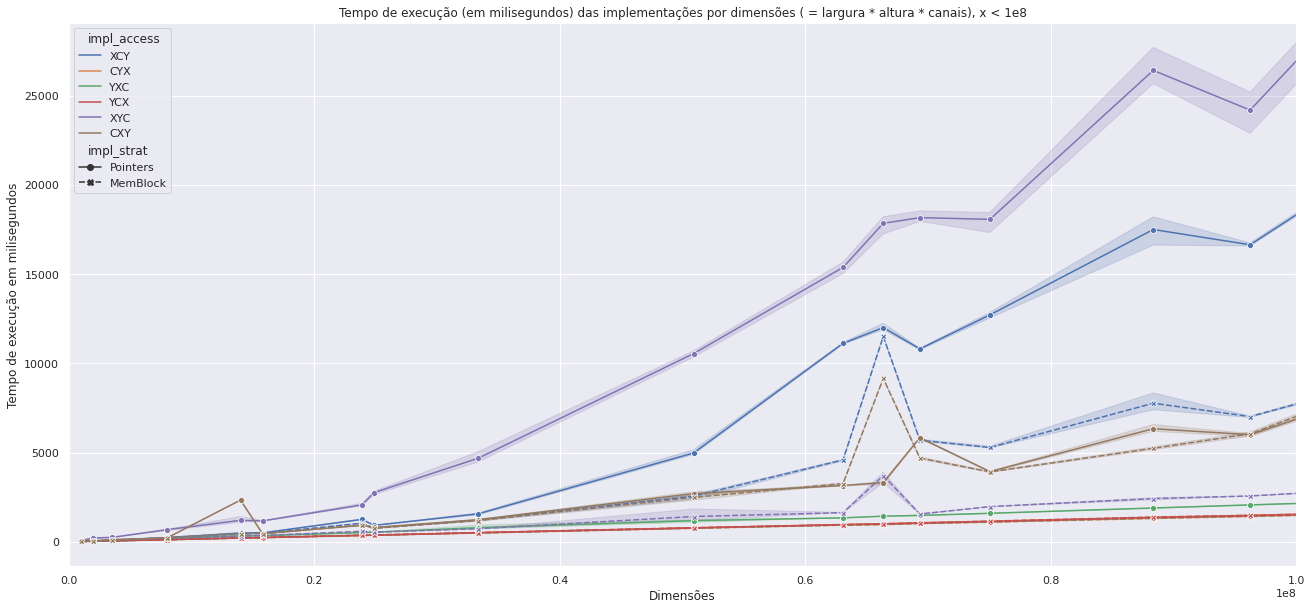

In [33]:
_plot_linegraph(df, ', x < 1e8', set_xlim=(0, 10**8))

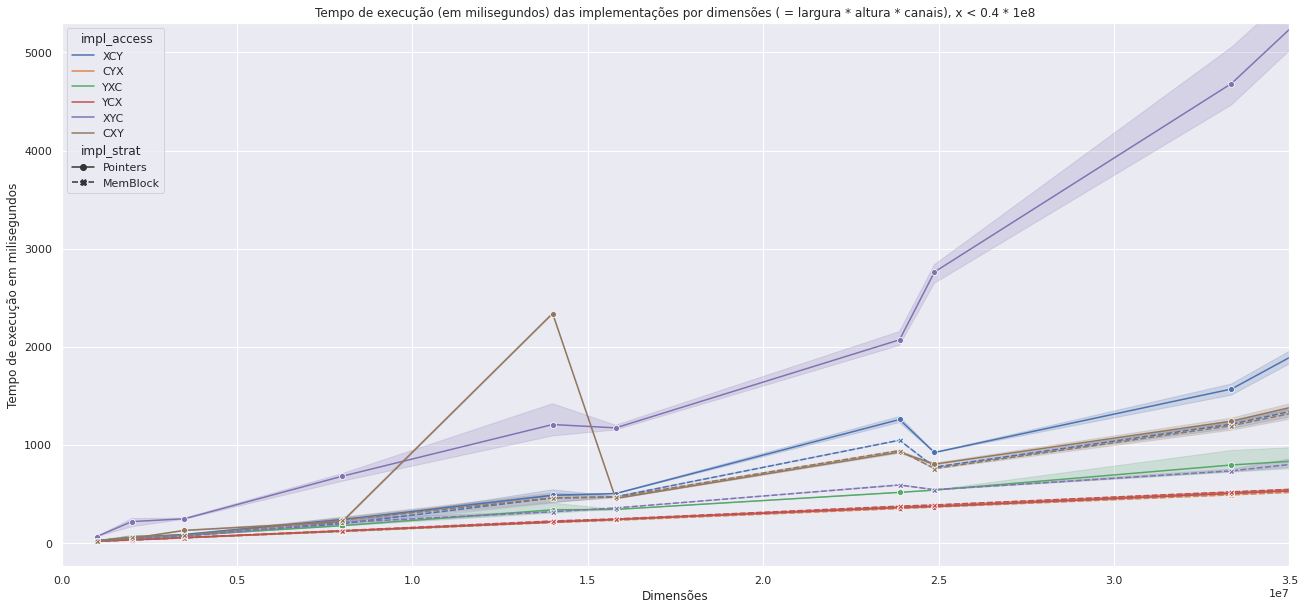

In [34]:
_plot_linegraph(df, ', x < 0.4 * 1e8', set_xlim=(0, 0.35*10**8))

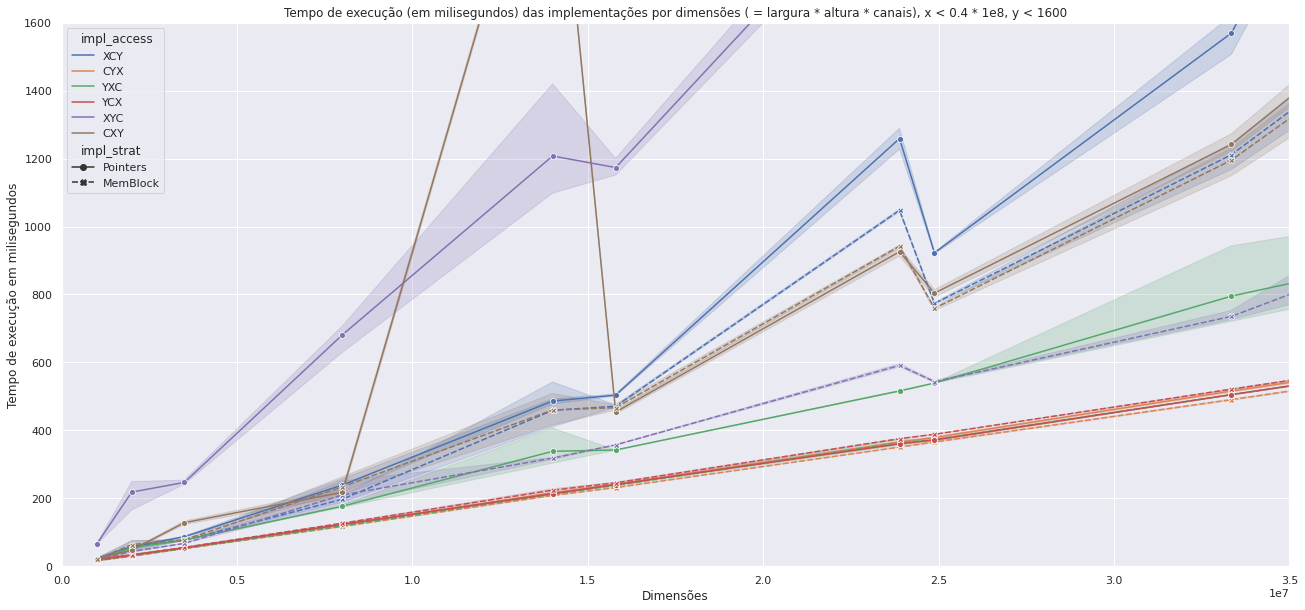

In [35]:
_plot_linegraph(df, ', x < 0.4 * 1e8, y < 1600', set_xlim=(0, 0.35*10**8), set_ylim=(0, 1.6*1e3))

In [36]:

def snsheatmap(*args, **kwargs):
    def _hm(fig, **kwargs):
        kwargs.setdefault('annot', True)
        kwargs.setdefault('fmt', 'g')
        kwargs.setdefault('robust', True)
        kwargs.setdefault('cmap', 'YlGnBu')
        sns.heatmap(*args, **kwargs)
    return default_plot(figsize=(16, 6), invok=_hm, **kwargs)

# _ = snsheatmap(np.log(_df1s), annot=_df1s, title='Tempo de execução (em '+_unit_df+') das implementações por arquivo', xlabel='Estratégia')

def get_imagesize(fn):
    from PIL import ImageFile

    ImPar=ImageFile.Parser()
    with open(fn, "rb") as f:
        ImPar=ImageFile.Parser()
        chunk = f.read(2048)
        count=2048
        while chunk != "":
            ImPar.feed(chunk)
            if ImPar.image:
                break
            chunk = f.read(2048)
            count+=2048
        return ImPar.image.size  # count

def get_images_input_folder(prefix='../input/'):
    return [prefix + i for i in os_listdir(prefix)]

# input_images_sizes = {i: get_imagesize(i) for i in get_images_input_folder()}
# __iis = pd.DataFrame([[i[0]*i[1], max(i[0], i[1])] for i in input_images_sizes.values()], columns=['x', 'y'])
# grid = sns.jointplot(data=__iis, x='x', y='y', height=6)
# plt.title('Title')
# # grid.set_axis_labels('aX', 'aY')

# default_plot(figsize=(16, 6))
# sns.histplot(df, x='D', stat='percent')

### Análise utilizando a ferramenta perf

In [37]:
def read_file_lines(fn):
    with open(fn, 'r') as fh:
        return fh.readlines()

def read_file_lines_optdif(fn):
    f = read_file_lines(fn)
    # clp = next((x[x.find(':')+2:] for x in f if 'solver' in x), '')
    def lineproc(i):
        # return prefix + i.strip() + ', ' + fn + ', ' + clp.strip() + '\n'
        return i.strip() + ', ' + fn.split('.')[-3] + (', Sim' if 'opt' in fn else ', Não') + '\n'
    return ''.join((i if i.startswith('#') else lineproc(i)) for i in f if i.strip())

_perf_ctext ='\n'.join([read_file_lines_optdif(i) for i in os_listdir('.') if '.csv' in i and 'perf' in i])
perf_df = (pd.read_csv(io.StringIO(_perf_ctext), sep=', ', engine='python', comment='#', 
                                         names=['implementation', 'file', 'width', 'height', 'channels', 'time', 'filtro', 'otimizado']))
# perf_df

Por fim, foram realizados alguns experimentos envolvendo a utilização da ferramenta `perf` do Linux para a demonstração da efetividade de algumas das técnicas apresentadas. Para tornar melhorar a visualização dos resultados, o programa foi compilado e testado em duas variantes distintas de acordo com o nível de otimização aplicado pelo compilador:

- Otimizado = Sim: Compilado utilizando o comando `make SYMBOLS=1`, cuja receita especifica as seguintes opções de compilação: `g++ -O5 -g3 -DNDEBUG -Wall -Wextra -Wl,--no-relax -std=c++17 -m64 -fPIC -fno-strict-aliasing -fexceptions -DIL_STD -MM`

- Otimizado = Não: Compilado utilizando o comando `make DEBUG=1 FSANITIZE=0`, cuja receita especifica as seguintes opções de compilação: `g++ -O0 -g3 -DONDEBUG -fno-omit-frame-pointer -Wall -Wextra -Wl,--no-relax -std=c++17 -m64 -fPIC -fno-strict-aliasing -fexceptions -DIL_STD -MM`

Tal diferenciação permite-nos visualizar quão agressivas e efetivas são as otimizações aplicadas pelo compilador em cima do código do branch *master*. A Tabela a seguir relaciona o desempenho dessas duas compilações de acordo com 3 filtros e 2 estratégias de implementação enquanto monitoradas pela ferramenta `perf record` em uma imagem em particular:

In [38]:
df_gen(perf_df).pivot_table(values='time', index=['filtro', 'otimizado'], columns=['impl_strat', 'impl_access'], aggfunc='sum')

impl_strat           MemBlock   Pointers
impl_access               YXC        XYC
filtro   otimizado                      
luma     Não         4421.947  54484.455
         Sim          291.159  14514.548
sobel    Não        29861.077  82207.161
         Sim         1936.343  28270.986
sobel_v2 Não        40265.409  90596.368
         Sim         5164.282  30235.507

O comando `perf stat` evidencia o impacto no *pipeline* e *cache* que a implementação Pointers@XYC, menos eficiente e intencionalmente programada com acesso invertido, possui: Durante a execução do filtro Sobel, o backend da CPU esteve 90% dos ciclos ocioso, provocando uma média de 0.37 instruções por ciclo e, conversamente, 2.47 ciclos estagnados por instrução. Por outro lado, na execução do mesmo problema com a mesma entrada, a implementação MemBlock@YXC obteve 70% de ciclos ociosos no backend da CPU, alcançando a marca de 2.24 instruções por ciclo e apenas 0.32 ciclos estagnados por instruções:

![Filtro Sobel, MemBlock@YXC Otimizado](report/sobelopt/sobel_mem.png)
![Filtro Sobel, Pointers@XYC Otimizado](report/p_sobelopt/sobel_point.png)

Além disso, é possível observar tanto através da ferramenta `perf report` quanto ao analisar o binário resultante, que, apesar das funções de acesso da imagem estarem devidamente encapsuladas em funções de alto nível na classe `Image3D` do arquivo `Image3D.hpp`, separada das implementações dos filtros (e estes utilizando essas funções de alto nível), o compilador foi completamente capaz de abstrair tais conceitos e fazer o *inlining* do *assembly* resultante. Note, nas imagens a seguir, que no binário otimizado não consta contribuições da classe Image3D, enquanto na versão **não**-otimizada as três primeiras linhas do relatório -e consequentemente aquelas com maior contribuição de tempo- são métodos da classe.

Resumo das contribuições em tempo de execução das funções do binário **NÃO**-otimizado (Sobel, MemBlock@YXC):
![Resumo das contribuições em tempo de execução das funções do binário NÃO-otimizado (Sobel, MemBlock@YXC)](report/sobel/summary.png)

Resumo das contribuições em tempo de execução das funções do binário otimizado (Sobel, MemBlock@YXC):
![Resumo das contribuições em tempo de execução das funções do binário otimizado (Sobel, MemBlock@YXC)](report/sobelopt/summary.png)

Nas imagens seguintes, é possível observar diversas instruções dedicadas a chamada de função (`callq`) presentes no assembly da versão **não**-otimizada, e nenhuma na versão otimizada:

Assembly da função *sobel* do binário **NÃO**-otimizado (Sobel, MemBlock@YXC):
![Assembly da função *sobel* do binário NÃO-otimizado (Sobel, MemBlock@YXC)](report/sobel/sqrt_impact.png)

Assembly da função *sobel* do binário otimizado (Sobel, MemBlock@YXC):
![Assembly da função *sobel* do binário otimizado (Sobel, MemBlock@YXC)](report/sobelopt/inline.png)

Ademais, é possível observar que a linha que possui a raiz quadrada tem um impacto significativo no desempenho da função:

Visão geral da função *sobel* em código, linha 86:
```C++
// Terminologia temporária: pixel = Unidade de uma imagem composta (geralmente) por três componentes de cor
//                        : subpixel = Componente valorado de cor de um pixel
const auto pvmax = ...; // Valor máximo que um subpixel pode assumir (geralmente 255)
const auto maxdiv = ...; // Valor máximo que a raiz quadrada std::sqrt(hor*hor + ver*ver) pode assumir (no Sobel)
triforImg(i2d, x, y, c) { // Macro para criação do for
    int hor = ..., ver = ...;
    // Linha 86: Ao dividir a raiz abaixo pelo valor máximo que ela pode assumir (maxdiv), seu intervalo ficará entre 0.0 e 1.0 (real)...
    dst(x, y, c) = pvmax*(std::sqrt(hor*hor + ver*ver)/maxdiv); // ...então ao multiplicar-se por 255, tem-se o intervalo 0 a 255 (pvmax)
    // dst é o buffer de saída, e também é uma imagem, logo cada subpixel deve estar entre 0 e 255
}
```

Assembly da função *sobel* do binário otimizado, linha 86 (Parte 1), (Sobel, MemBlock@YXC):
![Assembly da função *sobel* do binário otimizado, linha 86 (Parte 1), (Sobel, MemBlock@YXC)](report/sobelopt/sqrt0.png)

Assembly da função *sobel* do binário otimizado, linha 86 (Parte 2), (Sobel, MemBlock@YXC):
![Assembly da função *sobel* do binário otimizado, linha 86 (Parte 2), (Sobel, MemBlock@YXC)](report/sobelopt/sqrt1.png)

Assim sendo, uma modificação chamada *sobel_v2* foi desenvolvida com o intuito de remover a raiz quadrada, bem como sua multiplicação e divisão externa. Considerando que a expressão da raiz é convertida para um inteiro no intervalo de 0 a 255, e levando em conta que a soma do produtório pode atingir valores exorbitantes, foi implementado uma busca binária em um *array* de tamanho 256 cujos valores consistem na expressão calculada em cima do índice. Dessa forma, seriam necessárias apenas O(log2(N))=log2(256)=8 operações de comparação por iteração para obter um resultado equivalente da expressão da raiz. Lamentavelmente a estratégia desempenhou pior que a original, como demonstrado na Tabela apresentada anteriormente.

Visão geral da função *sobel_v2* em código:
```C++
// Terminologia temporária: pixel = Unidade de uma imagem composta (geralmente) por três componentes de cor
//                        : subpixel = Componente valorado de cor de um pixel
const auto pvmax = ...; // Valor máximo que um subpixel pode assumir (geralmente 255)
const auto maxdiv = ...; // Valor máximo que a raiz quadrada std::sqrt(hor*hor + ver*ver) pode assumir (no Sobel)
int bsrch[pvmax];
for (int i = 0; i < pvmax; i++) {
    const auto i_ = double((i+1)*maxdiv)/double(pvmax);
    bsrch[i] = int(i_*i_);
}
triforImg(i2d, x, y, c) { // Macro para criação do for
    int hor = ..., ver = ...;
    const int g2 = hor*hor + ver*ver;
    const int a = busca_binaria(bsrch, g2);
    dst(x, y, c) = a; // onde a é o índice na qual bsrch[a-1] <= g2 < bsrch[a]
}
```

Assembly da função *sobel_v2* do binário otimizado, destacando o overhead das instruções de pulo (Sobel_v2, MemBlock@YXC):
![Assembly da função *sobel_v2* do binário otimizado, destacando o overhead das instruções de pulo (Sobel_v2, MemBlock@YXC)](report/sobel2opt/overhead.png)